## Dynamics Learning and Localization (DLL) with 2 mass spring systems 


In [453]:
import numpy as np
import pysindy as ps
import scipy as sp

from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

from IPython.display import Image

In [462]:
differentiation_method = ps.FiniteDifference(order=2)

optimizer = ps.STLSQ(threshold=0.01)
lasso_optimizer = Lasso(alpha=0.001, max_iter=2000, fit_intercept=False)
sr3_optimizer = ps.SR3(threshold=0.1, nu=1)

poly_library = ps.PolynomialLibrary()
fourier_library = ps.FourierLibrary()
identity_library = ps.IdentityLibrary()
combined_library =  poly_library + identity_library + fourier_library

Primary system is the Observer and the second system is the feaeture. The derivation for the dynamics of both systems is as follows...

Newton's second law for the classical mass spring damper system.

$m\ddot{x} = - c\dot{x} - kx$

We make the substitution

$\dot{x} = v$

and write system in state space form,

$\dot{x} = v\\
\dot{v} = - \frac{c}{m}v - \frac{k}{m}x.$

In this case we neglect damping, meaning that

$c = 0$

resulting in the final system in state space form,

$\dot{x} = v\\
\dot{v} =  - \frac{k}{m}x.$

The systems are configured as...

In [454]:
Image(url= "./images/setup.jpg", width=750, height=200)

DLL is applied here following the derivation found in https://www.overleaf.com/project/5e5193431d431400019489a1 using the optimization functions...

In [455]:
Image(url= "./images/costfunction2.png", width=750, height=300)

## Initialization

In [541]:
dt = .1 #integtration time step
tf = 100
t = np.arange(0, tf, dt) #integration length

param_1 = 1 #Observer parameter k/m
param_2 = 1 #Feature parameter k/m

x_0 = [1, 0]  # Observer Initial Conditions [x1,x2]
x_3 = 0 #second spatial dimension used to calculate distance between observer and feature

y_0 = [-1, 0] # Observer Initial Conditions
y_3 = 0 # distance from observer

def observer(x, t): #Observer System
    return [
        x[1], #x_1 dot
        -param_1*x[0]] #x_2 dot

def feature(y, t): #Feature System
    return [
        y[1], #y1 dot
        -param_2*y[0]] #y2 dot

x = odeint(observer, x_0, t) # Generate measurement data in form [x1, x2]
y = odeint(feature, y_0, t) # Generate measurement data in form [y1, y2]
#y[:,0] = y[:,0]+3 


### System Trajectories

Text(0.5, 1.0, 'X-Y Trajectories')

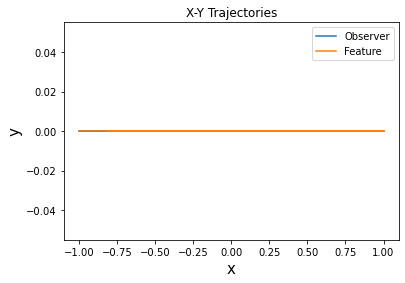

In [457]:
plt.plot(x[:,0],x_3*np.ones(x.shape[0]), label = 'Observer')
plt.plot(y[:,0],y_3*np.ones(y.shape[0]), label = 'Feature')
plt.legend()
plt.xlabel('x', fontsize = 15)
plt.ylabel('y', fontsize = 15)
plt.title('X-Y Trajectories')

### Sytem Dynamics

<ipython-input-458-22ac26fdb033>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
<ipython-input-458-22ac26fdb033>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


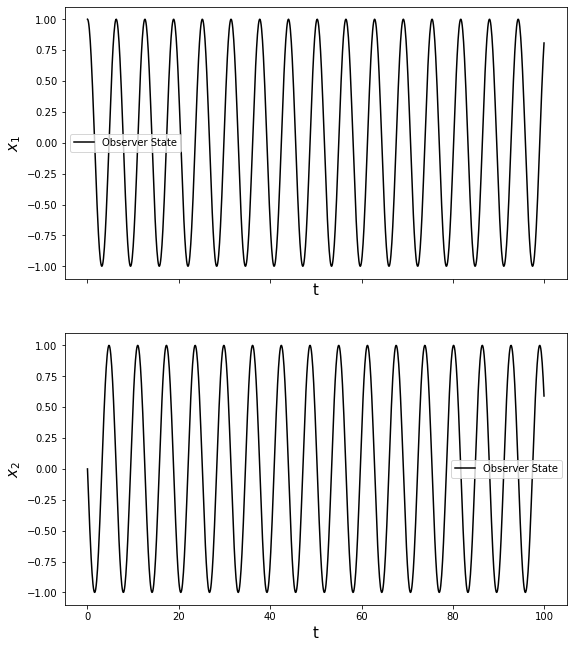

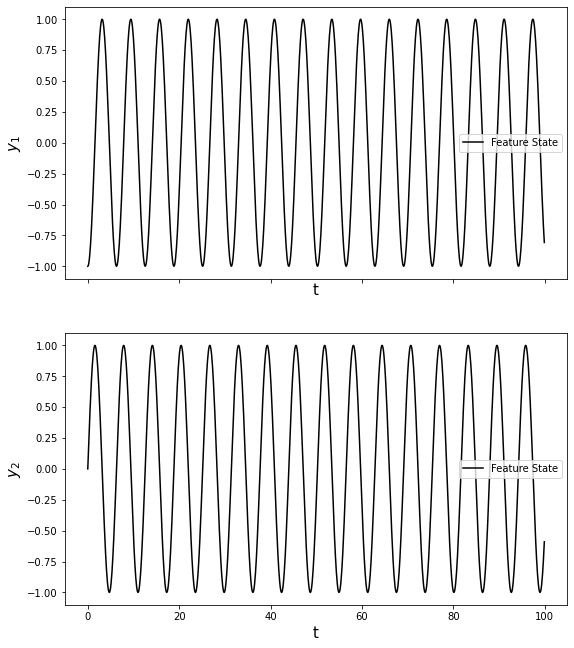

In [458]:
fig1, axs = plt.subplots(x.shape[1], 1, sharex=True, figsize=(9, 11))
for i in range(x.shape[1]):
    axs[i].plot(t, x[:, i], 'k', label='Observer State')
    #axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    #axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i+1))
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$x_{}$'.format(i+1), fontsize = 15)
fig1.show()

fig2, axs = plt.subplots(y.shape[1], 1, sharex=True, figsize=(9, 11))
for i in range(y.shape[1]):
    axs[i].plot(t, y[:, i], 'k', label='Feature State')
    #axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    #axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i+1))
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$y_{}$'.format(i+1), fontsize = 15)
fig2.show()

## Simulated Sensors

### Noisy relative position measurement

In [459]:
delta = y-x

#Stochastic sensor on the observer
rel_sense_mean = 0 #mean of relative measurement sensor
rel_sense_std = 0.3#[0,0]-y[0,0]) * 0.3 #standard deviation of relative measurement scales with the distance
delta_noise = delta + np.random.normal(rel_sense_mean,rel_sense_std,size=delta.shape)
delta_noise

array([[-1.78485616,  0.14614038],
       [-1.95792921, -0.02236167],
       [-2.30031363,  0.35811842],
       ...,
       [-1.48064592, -1.37449394],
       [-1.5877474 , -1.426113  ],
       [-1.16055148, -1.20528612]])

Text(0, 0.5, 'delta position')

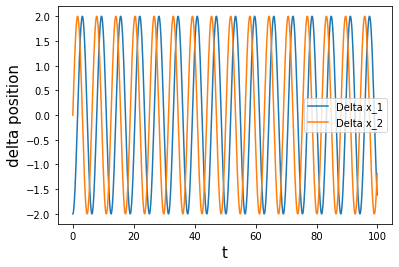

In [460]:
plt.plot(t,delta[:,0], label = 'Delta x_1')
plt.plot(t,delta[:,1], label = 'Delta x_2')
plt.legend()
plt.xlabel('t', fontsize = 15)
plt.ylabel('delta position', fontsize = 15)
#plt.title('X-Y Trajectories')

### Noisy IMU sensor simulation + dead reconing


Text(0, 0.5, 'm/s^2, m/s, m')

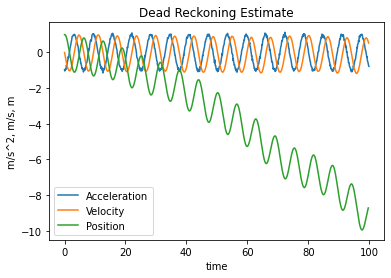

In [512]:
acc = -param_1*x[:,0] #analytical acceleration

#Stochastic IMU sensor parameters
imu_mean = 0
imu_std = 0.05

#Simulated Noisy IMU
acc_noise = acc+np.random.normal(imu_mean,imu_std,size=acc.shape)
#Plot noisy acceleration over time
plt.plot(t,acc_noise, label = 'Acceleration') 

#Integrate Acceleration
vel_noise = np.zeros(acc_noise.size-1)
for jj in range(1,vel_noise.size):
    vel_noise[jj] = acc_noise[jj-1]*dt+vel_noise[jj-1]
plt.plot(t[0:vel_noise.size],vel_noise, label = 'Velocity') # dead reckoned velocity of observer over time

#Integrate Velocity
pos_noise = np.zeros(vel_noise.size-1)
pos_noise[0] = x_0[0]
for jj in range(1,pos_noise.size):
    pos_noise[jj] = vel_noise[jj-1]*dt+pos_noise[jj-1]
plt.plot(t[0:pos_noise.size],pos_noise, label = 'Position') # dead reckoned position of observer over time

dead_reck = np.ones((x.shape[0], 2))
#dead_reck = np.append(dead_reck, vel_noise, axis = 0)
dead_reck[0:pos_noise.size,0] = pos_noise
dead_reck[0:vel_noise.size,1] = vel_noise

y_dead_reck = delta+dead_reck

plt.title('Dead Reckoning Estimate')
plt.legend()
plt.xlabel('time')
plt.ylabel('m/s^2, m/s, m')

## DLL Optimization loop

In [566]:
R_inv = 1#np.ones((2,1)) #Observer process information matrix
Q_inv = 1#np.ones((2,1)) #measurement information matrix
S_inv = 1#np.ones((2,1)) #Feature process information matrix
P_inv = 1#np.ones((2,1)) #Identification information matrix

x_est = x_0 #initialize observer estimate
y_est = y_0 #initialize feature estimate

y_up = y_est #initial feature process update

X = np.array([x_est])
Y = np.array([y_est])

params = np.array([[1,1,1,1], [1,1,1,1]])
B = np.array([params])

def sinusoid(tt, a, b, c, d):
    return a * np.sin(b * (tt+c))+d 
    
x_pos_std= 0.05

for i in range (950):#int(tf/dt)-1):
    t_sim = i*dt
    
    #calculate the Observer process update f(x_k-1) with noise
    x_up = odeint(observer, x_est, [t_sim,t_sim+1]) 
    x_up = x_up[1,:] 
    x_up = x_up + np.random.normal(0,x_pos_std,size=x_up.shape)

    y_up = [sinusoid(t_sim+dt, *params[0]), sinusoid(t_sim+dt, *params[1])] #feature process updateate

 st]
    #define filtering cost function
    def pos_opt(x): #Position dimension cost function
        return (x[0] - x_up[0]) ** 2 * R_inv + (x[2] - y_up[0]) ** 2 * S_inv + (delta_noise[i,0] - (x[2]-x[0])) ** 2 * Q_inv

    def vel_opt(x): #Velocity dimension cost function   
        return (x[1] - x_up[1]) ** 2 * R_inv + (x[3] - y_up[1]) ** 2 * S_inv + (delta_noise[i,1] - (x[3]-x[1])) ** 2 * Q_i
v}

    #minimize one time step (Filterin
    x_init = [x_est, y_est] #set optimization initial conditions
g!)
    pos_min=sp.optimize.minimize(pos_opt, x_init) #minimize position dimension
    vel_min=sp.optimize.minimize(vel_opt, x_init) #minimize velocity dimension
 
       x_est = np.array([pos_min.x[0], vel_min.x[1]]) # save x_est
    X = np.append(X, [x_est], axis=0) #update trajectory
 
       y_est = np.array([pos_min.x[2], vel_min.x[3]]) #save y_est
    Y = np.append(Y, [y_est], axis=0) #update trajecto
    #Dynamics Learningry

  # if i100> 3: #delay model learning for a number of time st eps
      g (SIDY)
        # model.fit(Y,t=
   
        #calculate the feature process update based on most recent dynamics estimate g(y_k-1)
        # y_up = model.simulate(y_est,[t_sim,t_sim+1])[1,:        ]

#Sinusoidal Regress+        pos_params, pos_params_cov = sp.optimize.curve_fit(sinusoid, t[0:Y.shape[0]], Y[:,0])
        vel_params, vel_params_cov = sp.optimize.curve_fit(sinusoid, t[0:Y.shape[0]], Y[:,1])
        #print(pos_params)
        #print(vel_params)
        params = np.array([pos_params, vel_params])
        B = np.append(B, [params], axis = 0)
    else:
        B = np.append(B, [params], axis = 0)
ms)

### Plot estimated trajectories


<ipython-input-579-05d0e1f45c93>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
<ipython-input-579-05d0e1f45c93>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
<ipython-input-579-05d0e1f45c93>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


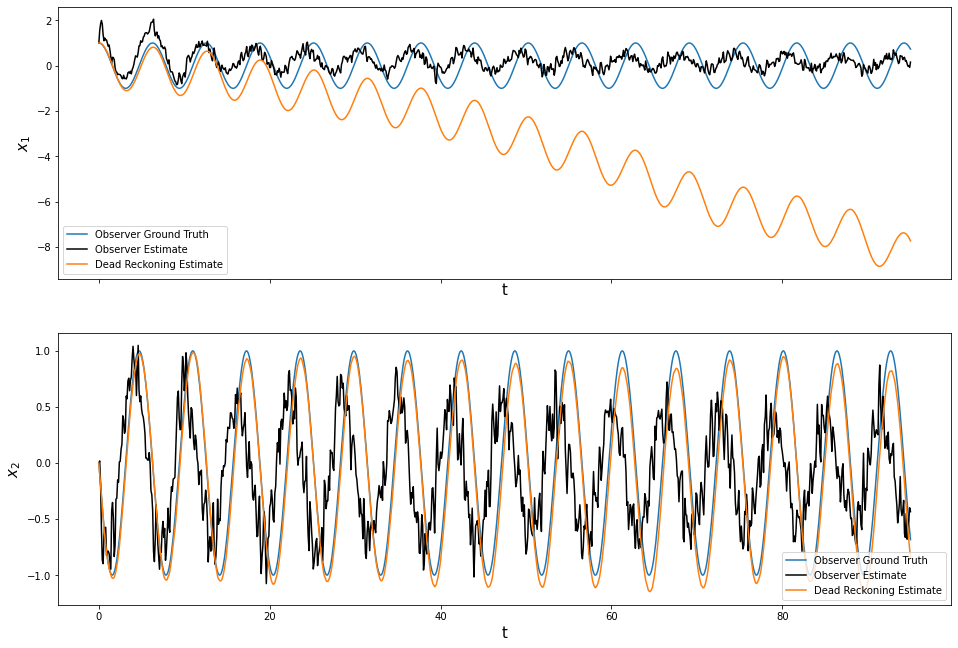

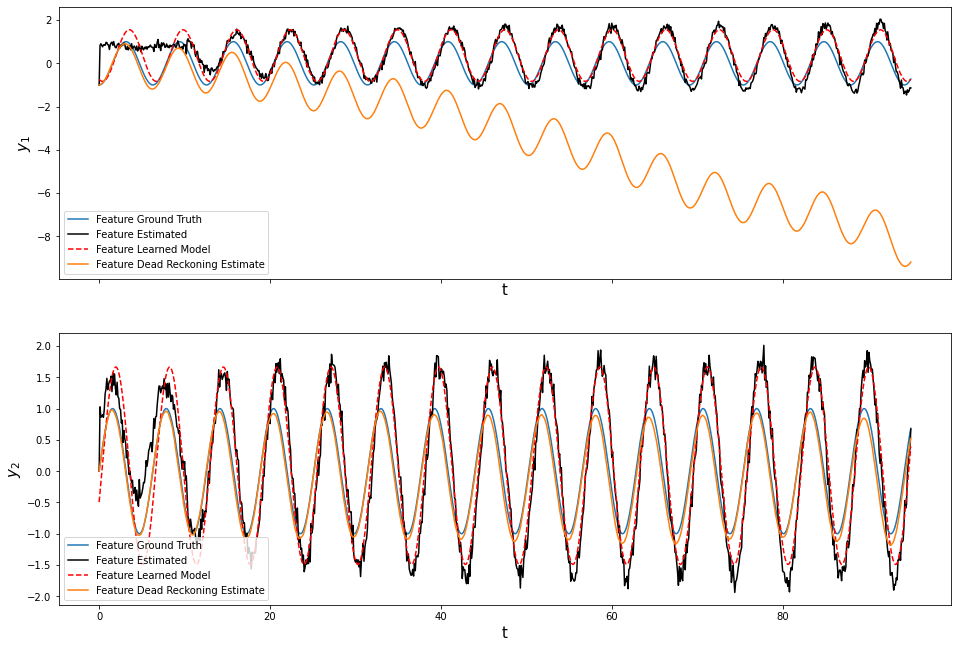

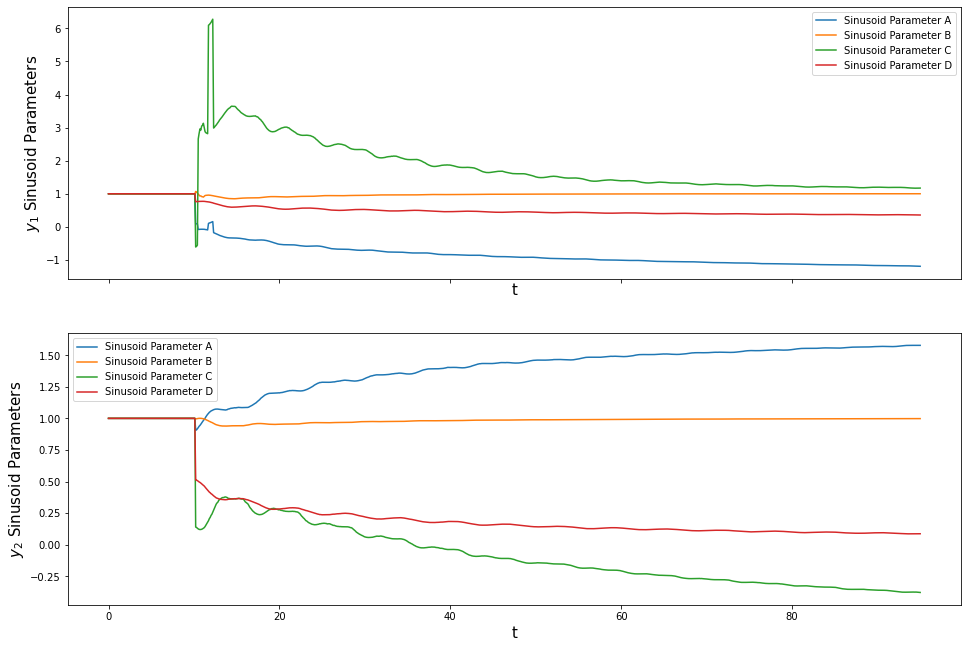

In [579]:
fig1, axs = plt.subplots(X.shape[1], 1, sharex=True, figsize=(16, 11))
for i in range(X.shape[1]):
    axs[i].plot(t[0:X.shape[0]], x[0:X.shape[0], i] , label='Observer Ground Truth')
    axs[i].plot(t[0:X.shape[0]], X[:, i], 'k', label='Observer Estimate')
    axs[i].plot(t[0:X.shape[0]], dead_reck[0:X.shape[0], i], label='Dead Reckoning Estimate')
    #axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$x_{}$'.format(i+1), fontsize = 15)
fig1.show()

fig2, axs = plt.subplots(Y.shape[1], 1, sharex=True, figsize=(16, 11))
for i in range(Y.shape[1]):
    axs[i].plot(t[0:Y.shape[0]], y[0:Y.shape[0], i], label='Feature Ground Truth')
    axs[i].plot(t[0:Y.shape[0]], Y[:, i], 'k', label='Feature Estimated')
    #axs[i].plot(t[0:Y.shape[0]], y_learn[:, i], 'r--', label='model simulation')
    axs[i].plot(t[0:Y.shape[0]], sinusoid(t[0:Y.shape[0]], *params[i]), 'r--', label='Feature Learned Model')
    axs[i].plot(t[0:Y.shape[0]], y_dead_reck[0:Y.shape[0], i], label='Feature Dead Reckoning Estimate')
    axs[i].legend()
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$y_{}$'.format(i+1), fontsize = 15)
fig2.show()

fig3, axs = plt.subplots(Y.shape[1], 1, sharex=True, figsize=(16, 11))
for i in range(Y.shape[1]):
    axs[i].plot(t[0:Y.shape[0]], B[0:Y.shape[0], i, 0], label='Sinusoid Parameter A'(
    axs[i].plot(t[0:Y.shape[0]], B[0:Y.shape[0], i, 1], label='Sinusoid Parameter B')
    axs[i].plot(t[0:Y.shape[0]], B[0:Y.shape[0], i, 2], label='Sinusoid Parameter C')
    axs[i].plot(t[0:Y.shape[0]], B[0:Y.shape[0], i, 3], label='Sinusoid Parameter D')ied')
    axs[i].legend()
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$ Sinusoid Parametersy_{}$'.format(i+1), fontsize = 15)
fig3.show()

In [356]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=identity_library,
    optimizer=optimizer, feature_names=["y_1", "y_2"])
model.fit(Y,t=dt)


SINDy(differentiation_method=FiniteDifference(),
      feature_library=<pysindy.feature_library.identity_library.IdentityLibrary object at 0x7fa495063a30>,
      feature_names=['y_1', 'y_2'], optimizer=STLSQ(threshold=0.01))

In [357]:
model.print()       
y_learn = model.simulate(y_0, t[0:Y.shape[0]])


y_1' = 0.162 y_1 + 0.897 y_2
y_2' = -0.387 y_1 + -0.059 y_2


In [561]:
B

array([[[ 1.        ,  1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ,  1.        ]],

       [[ 0.0996085 ,  1.07724178, -0.58478871,  0.75948433],
        [ 0.90602986,  0.99541665,  0.14192306,  0.50953124]],

       [[ 0.09226423,  1.05919402, -0.5658687 ,  0.76267702],
        [ 0.90931839,  0.99628951,  0.13855531,  0.5079413 ]],

       ...,

       [[-1.17264579,  1.00010674,  1.19623491,  0.36090529],
        [ 1.56954131,  0.9976525 , -0.36811897,  0.09293422]],

       [[-1.17264728,  1.0001106 ,  1.1960709 ,  0.36093587],
        [ 1.57019263,  0.99765826, -0.36831436,  0.09325951]],

       [[-1.17261665,  1.00009418,  1.19677016,  0.36080548],
        [ 1.57011197,  0.9976579 , -0.36830141,  0.0932197 ]]])

In [ ]:
    #Full cost function in vector form.         
    #(np.array([x[0],x[1]]) - np.array(x_up)) ** 2 * R_inv + (np.array([x[2],x[3]]) - np.array(y_up)) ** 2 * S_inv + (delta_noise - np.array([x[2]-x[0],x[3]-x[1]]))        ** 2 * Q_inv}
